<a href="https://colab.research.google.com/github/festa78/colab_experiments/blob/master/semiconv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiments to reproduce the section 4.1 Synthetic experiments in the paper ["Semi-convolutional Operators for Instance Segmentation"](https://arxiv.org/abs/1807.10712)

This paper proposes semi convolutional operator, which adds the pixel location to a convolution layer, for instance segmentation.  

In the section 4.1, the authors conducted the experiment to synthetic data to verify their idea.  

In this notebook I tried to reproduce the resulits by the followings:

* Create a dot image with instance IDs.

* Implement simplified and truncated ResNet with semi convolutional operator by eq.(3) and (6).

* Train the model on the dot image with the loss function (5).

* Compare kmeans clustering results before and after the training and make sure it can reproduce the result in the Fig. 3.



In [1]:
# Set up the environment.
!pip install tensorflow==2.0.0-beta1 opencv-python

In [0]:
# Import Python libraries.
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Add, Input, Conv2D, BatchNormalization,
                                     Activation, MaxPooling2D)

W0810 08:01:33.651511 139641634342784 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape (32, 32, 3)


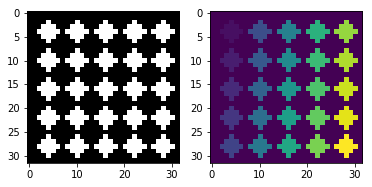

In [3]:
# Create a dot image.
NUM_DOTS_PER_ROW = 5
RADIUS_PIXEL = 2
num_classes = NUM_DOTS_PER_ROW ** 2

image_size = NUM_DOTS_PER_ROW * (RADIUS_PIXEL * 3) + RADIUS_PIXEL
image = np.zeros((image_size, image_size, 3), np.float32)
label = np.zeros((image_size, image_size), np.uint8)

for i in range(NUM_DOTS_PER_ROW):
  for j in range(NUM_DOTS_PER_ROW):
    cv2.circle(image, (i * (RADIUS_PIXEL * 3) + 2 * RADIUS_PIXEL, j * (RADIUS_PIXEL * 3) + 2 * RADIUS_PIXEL), RADIUS_PIXEL, (255, 255, 255), -1)
    cv2.circle(label, (i * (RADIUS_PIXEL * 3) + 2 * RADIUS_PIXEL, j * (RADIUS_PIXEL * 3) + 2 * RADIUS_PIXEL), RADIUS_PIXEL, (i * NUM_DOTS_PER_ROW + j) + 1, -1)
    
print('image shape', image.shape)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(label)

In [0]:
# Define truncated ResNet50.
# No pooling and Conv2D strides for simplicity.
class ResNet50Trunc(object):
    '''
    Reference:
        "Deep Residual Learning for Image Recognition"
        https://arxiv.org/abs/1512.03385
    '''
    def __init__(self, input_shape, output_dim=8, semi_conv=False):
      x = Input(shape=input_shape)
      h = Conv2D(64, kernel_size=(7, 7), padding='same')(x)
      h = BatchNormalization()(h)
      h = Activation('relu')(h)

      h = self._building_block(h, channel_out=64)
      h = self._building_block(h, channel_out=64)
      h = self._building_block(h, channel_out=64)

      h = Conv2D(output_dim, kernel_size=(1, 1), strides=(1, 1), padding='same')(h)
      if semi_conv:
        h = self._semi_conv(h)
      h = Conv2D(output_dim, kernel_size=(1, 1), strides=(1, 1), padding='same')(h)
      if semi_conv:
        h = self._semi_conv(h)
      y = Conv2D(output_dim, kernel_size=(1, 1), strides=(1, 1), padding='same')(h)
      if semi_conv:
        y = self._semi_conv(y)
      self.model = Model(x, y)

    def __call__(self, x):
      return self.model(x)

    def _semi_conv(self, x):
      # The semiconvolutional operator introduced by the paper.
      height = tf.shape(x)[1]
      width = tf.shape(x)[2]
      channel = tf.shape(x)[3]
      u_x = tf.cast(tf.range(height), tf.float32) / tf.cast(height, tf.float32)
      u_x = tf.reshape(u_x, (1, height, 1, 1))
      u_x = tf.tile(u_x, (1, 1, width, 1))
      u_y = tf.cast(tf.range(width), tf.float32) / tf.cast(width, tf.float32)
      u_y = tf.reshape(u_y, (1, 1, width, 1))
      u_y = tf.tile(u_y, (1, height, 1, 1))
      u_other = tf.zeros_like(x)[..., :-2]
      u = tf.concat((u_x, u_y, u_other), 3)
      return x + u
      
    def _building_block(self, x, channel_out=256):
      channel = channel_out // 4
      h = Conv2D(channel, kernel_size=(1, 1), padding='same')(x)
      h = BatchNormalization()(h)
      h = Activation('relu')(h)
      h = Conv2D(channel, kernel_size=(3, 3), padding='same')(h)
      h = BatchNormalization()(h)
      h = Activation('relu')(h)
      h = Conv2D(channel_out, kernel_size=(1, 1), padding='same')(h)
      h = BatchNormalization()(h)
      shortcut = self._shortcut(x, output_shape=h.get_shape().as_list())
      h = Add()([h, shortcut])
      return Activation('relu')(h)

    def _shortcut(self, x, output_shape):
      input_shape = x.get_shape().as_list()
      channel_in = input_shape[-1]
      channel_out = output_shape[-1]

      if channel_in != channel_out:
        return self._projection(x, channel_out)
      else:
        return x

    def _projection(self, x, channel_out):
      return Conv2D(channel_out, kernel_size=(1, 1), padding='same')(x)

In [0]:
# Loss function from eq.(5).
def loss(feature, label_gt, num_classes):
  # Assume id=0 is background.
  loss_total = 0.
  for i in range(1, num_classes + 1):
    mask = tf.equal(label_gt, i)
    num_pixels_i = tf.reduce_sum(tf.cast(mask, tf.float32))

    feature_mask = tf.boolean_mask(feature, mask)
    centroid = tf.reduce_sum(feature_mask, axis=[0]) / num_pixels_i
    centroid = tf.reshape(centroid, (1, 1, 1, tf.shape(centroid)[0]))

    loss_i = tf.boolean_mask(feature - centroid, mask)
    loss_i = tf.norm(loss_i, axis=1)
    loss_i = tf.reduce_sum(loss_i) / num_pixels_i
    loss_total += loss_i
    
  loss_total /= num_classes
  return loss_total  

In [0]:
# Normal ResNet.
model = ResNet50Trunc((image_size, image_size, 3), 8, False)
#model.model.summary()

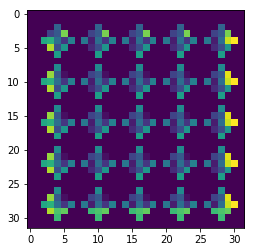

In [7]:
image_tf = tf.expand_dims(tf.convert_to_tensor(image / 255.), axis=0)
label_tf = tf.expand_dims(tf.convert_to_tensor(label), axis=0)

# kmeans on embedded features before training.
feature_np = model(image_tf).numpy()
feature_flat = feature_np.reshape((image_size ** 2, 8))
label_flat= label.flatten()
feature_mask = feature_flat[label_flat > 0]

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(feature_mask)
labels_pred = np.zeros_like(label_flat)
labels_pred[label_flat > 0] = kmeans.labels_ + 1
labels_pred = labels_pred.reshape((image_size, image_size))

plt.figure()
plt.imshow(labels_pred)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(100):
  with tf.GradientTape() as tape:
    feature = model(image_tf)
    l = loss(feature, label_tf, num_classes)
  
  grads = tape.gradient(l, model.model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.model.trainable_weights))
  
  if i % 20 == 0:
    print(l)

W0810 08:01:35.226979 139641634342784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tf.Tensor(0.17872804, shape=(), dtype=float32)
tf.Tensor(0.006276378, shape=(), dtype=float32)
tf.Tensor(0.0009974083, shape=(), dtype=float32)
tf.Tensor(0.0003662576, shape=(), dtype=float32)
tf.Tensor(0.00024741236, shape=(), dtype=float32)


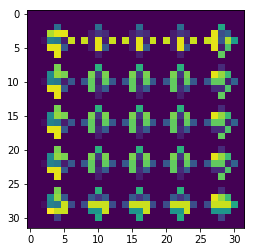

In [9]:
# kmeans on embedded features after training.
feature_np = model(image_tf).numpy()
feature_flat = feature_np.reshape((image_size ** 2, 8))
label_flat= label.flatten()
feature_mask = feature_flat[label_flat > 0]

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(feature_mask)
labels_pred = np.zeros_like(label_flat)
labels_pred[label_flat > 0] = kmeans.labels_ + 1
labels_pred = labels_pred.reshape((image_size, image_size))

plt.figure()
plt.imshow(labels_pred)

In [0]:
# ResNet with semi convolutions.
model = ResNet50Trunc((image_size, image_size, 3), 8, True)
#model.model.summary()

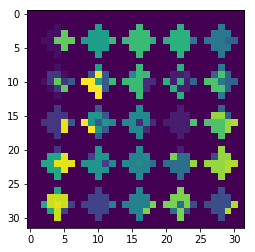

In [11]:
image_tf = tf.expand_dims(tf.convert_to_tensor(image / 255.), axis=0)
label_tf = tf.expand_dims(tf.convert_to_tensor(label), axis=0)

# kmeans on embedded features before training.
feature_np = model(image_tf).numpy()
feature_flat = feature_np.reshape((image_size ** 2, 8))
label_flat= label.flatten()
feature_mask = feature_flat[label_flat > 0]

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(feature_mask)
labels_pred = np.zeros_like(label_flat)
labels_pred[label_flat > 0] = kmeans.labels_ + 1
labels_pred = labels_pred.reshape((image_size, image_size))

plt.figure()
plt.imshow(labels_pred)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(100):
  with tf.GradientTape() as tape:
    feature = model(image_tf)
    l = loss(feature, label_tf, num_classes)
  
  grads = tape.gradient(l, model.model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.model.trainable_weights))
  
  if i % 20 == 0:
    print(l)

tf.Tensor(0.19716066, shape=(), dtype=float32)
tf.Tensor(0.016826805, shape=(), dtype=float32)
tf.Tensor(0.0047956104, shape=(), dtype=float32)
tf.Tensor(0.0027637177, shape=(), dtype=float32)
tf.Tensor(0.0031715014, shape=(), dtype=float32)


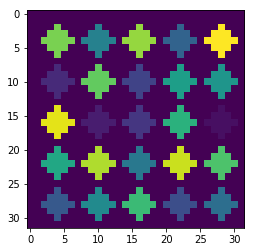

In [13]:
# kmeans on embedded features after training.
feature_np = model(image_tf).numpy()
feature_flat = feature_np.reshape((image_size ** 2, 8))
label_flat= label.flatten()
feature_mask = feature_flat[label_flat > 0]

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(feature_mask)
labels_pred = np.zeros_like(label_flat)
labels_pred[label_flat > 0] = kmeans.labels_ + 1
labels_pred = labels_pred.reshape((image_size, image_size))

plt.figure()
plt.imshow(labels_pred)